# Daniel Lupercio HW2

* Intel Image Classification

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import pandas as pd
import numpy as np
import os
import cv2 
import random
from pathlib import Path
from tqdm import tqdm
from sklearn.utils import shuffle
#from tensorflow.keras import layers, Dense, Input, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.model_selection import train_test_split
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
#import tensorflow_datasets as tfds
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.model_selection import train_test_split
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

## c) Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation

In [3]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image = np.array(image)
            image = image / 255
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

This takes approximately 42 seconds to run

In [4]:
train_Images, train_Labels = get_images('C:/Users/Daniel/Downloads/Intel_images/seg_train/seg_train/') #Extract the training images from the folders.

train_Images = np.array(train_Images) #converting the list of images to numpy array.
train_Labels = np.array(train_Labels)

Lets find shape of our traing data.

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you do not resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.

In [5]:
print("Shape of training Images:",train_Images.shape)
print("Shape of training Labels:",train_Images.shape)

Shape of training Images: (14034, 150, 150, 3)
Shape of training Labels: (14034, 150, 150, 3)


In [21]:
(train_Images).dtype

dtype('float64')

Let us look some random images of our dataset.

In [6]:
randint(0,len(train_Images))
#get_classlabel(train_Labels[rnd_number])

12818

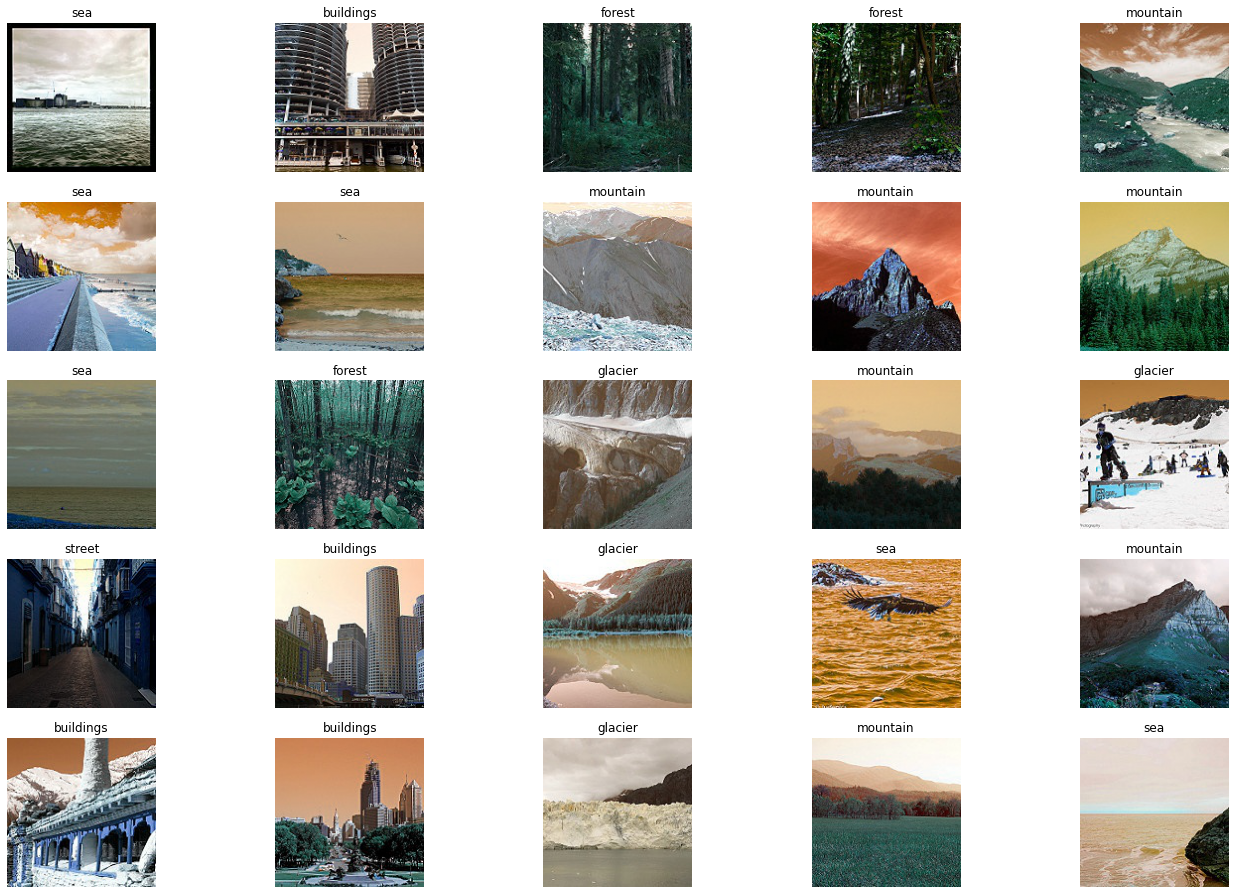

In [7]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_Images))
        ax[i,j].imshow(train_Images[rnd_number])
        ax[i,j].set_title(get_classlabel(train_Labels[rnd_number]))
        ax[i,j].axis('off')

## b) Split it into a training set, a validation set, and a test set. 

We already have a training set. If we pass through the test set directory, we can return the testing images.
We can create the validation set from the training set. Let's give that a shot here. I will subset the last 600 images from the training set. I can not ensure that 100 images of each class are in this validation set.

In [8]:
valid_Images = train_Images[-600:]
print(valid_Images.shape)
valid_Labels = train_Labels[-600:]
print(valid_Labels.shape)

(600, 150, 150, 3)
(600,)


That seemed to work, so lets plot some of the images from the validation set

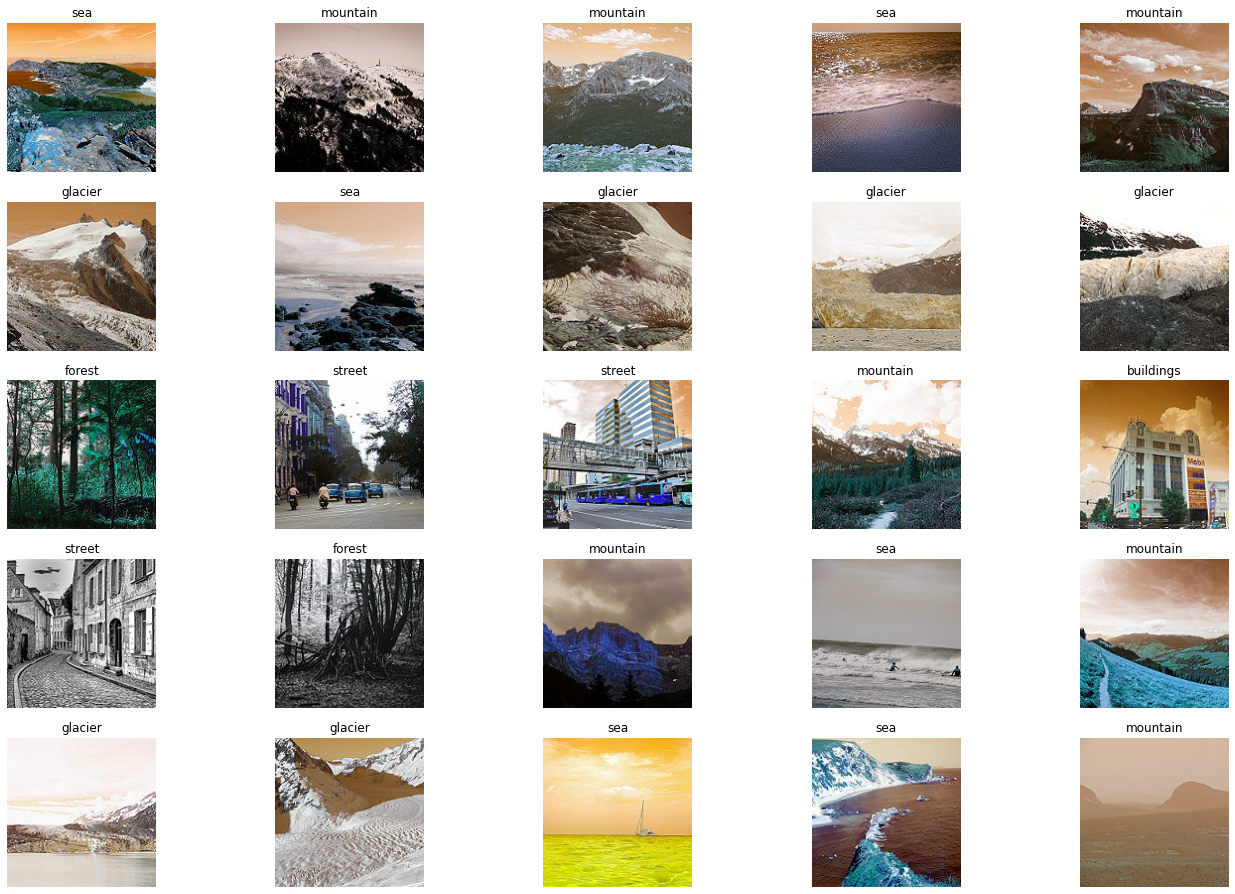

In [9]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(valid_Images))
        ax[i,j].imshow(valid_Images[rnd_number])
        ax[i,j].set_title(get_classlabel(valid_Labels[rnd_number]))
        ax[i,j].axis('off')

### Now lets get the images from the testing directory.
I am not sure if the size difference in the train, test and validation sets will create any difficulty in creating the models later. 

Now, Create the CNN model to predict the class labels.This is the basic CNN model. Getting the test images took approximately 9 seconds.

In [10]:
test_Images, test_Labels = get_images('C:/Users/Daniel/Downloads/Intel_images/seg_test/seg_test/') #Extract the testing images from the folders.
#C:\Users\Daniel\Downloads\Intel_images\seg_test\seg_test

In [11]:
test_Images = np.array(test_Images) #converting the list of images to numpy array.
test_Labels = np.array(test_Labels)

In [12]:
print(test_Images.shape)
print(test_Labels.shape)
#Labels are the same amount

(3000, 150, 150, 3)
(3000,)


Lets plot the testing sets to ensure we have properly imported them

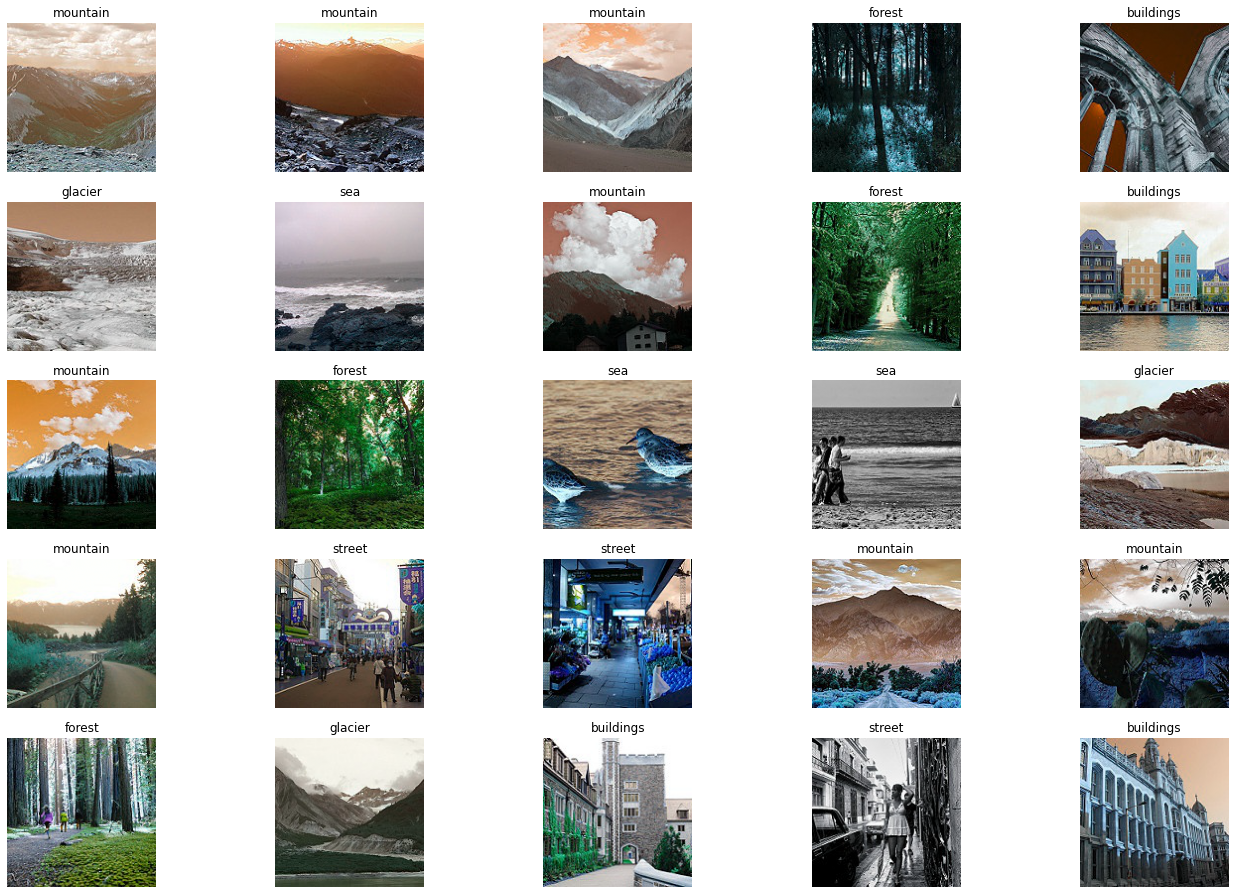

In [13]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(test_Images))
        ax[i,j].imshow(test_Images[rnd_number])
        ax[i,j].set_title(get_classlabel(test_Labels[rnd_number]))
        ax[i,j].axis('off')

## (d) Fine-tune a pretrained model on this dataset.

In [14]:
train_dataset_size = len(train_Images)
valid_dataset_size = len(valid_Images)
print(train_dataset_size)
print(train_Images.shape)
batch_size = 32
n_classes = np.count_nonzero(np.unique(train_Labels)) + 1 #should be 6

14034
(14034, 150, 150, 3)


In [15]:
print(n_classes)

6


I originally wanted to follow along the HOML Ch.14 sections: Pretrained Models for Transfer Learning for this part of the problem. That led me to define the train_dataset_size, valid_dataset_size, batch_size and n_classes. Then when it came time to run the history = model.fit(...). I ran into some errors: "ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()". This is something to do with the way my train_images array was created. I attempted to convert the values from uint8 to float32 using 'tf.image.convert_image_dtype'. But that conversion returned the same error. 

In [16]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [70]:
# for index, layer in enumerate(base_model.layers):
#     print(index, layer.name)

C:\Users\Daniel\anaconda3\envs\sfds\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 50)        4

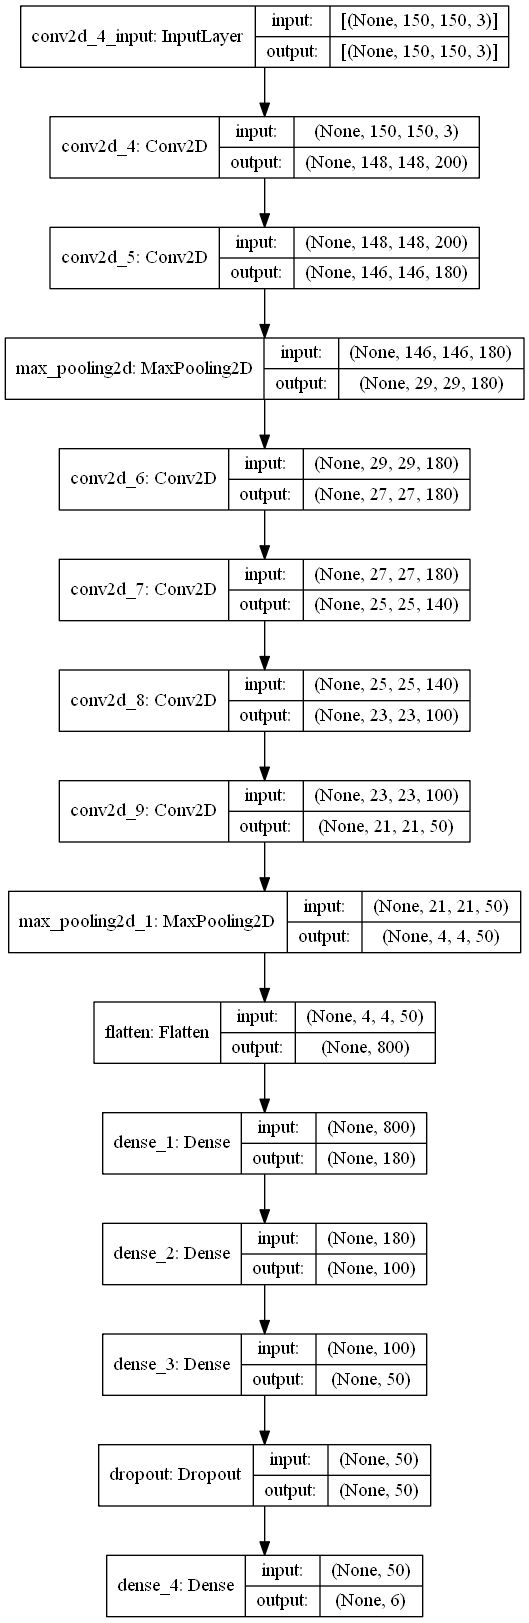

In [22]:
model = Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

I will admit that the amount of convolutional layers will lead me to belive that this model will overfit the data.

In [66]:
print(train_Labels.shape)
print(train_Images.shape)

(14034,)
(14034, 150, 150, 3)


Each epoch took approximately 30 minutes to complete

In [27]:
trained = model.fit(train_Images,train_Labels,epochs=5,validation_split=0.30) # validation_split=0.30

Epoch 1/5
307/307 [==============================] - 1766s 6s/step - loss: 1.1532 - accuracy: 0.5427 - val_loss: 0.9844 - val_accuracy: 0.6001
Epoch 2/5
307/307 [==============================] - 1769s 6s/step - loss: 1.0646 - accuracy: 0.5832 - val_loss: 0.8702 - val_accuracy: 0.6557
Epoch 3/5
307/307 [==============================] - 1766s 6s/step - loss: 0.9332 - accuracy: 0.6447 - val_loss: 0.7860 - val_accuracy: 0.7134
Epoch 4/5
307/307 [==============================] - 1764s 6s/step - loss: 0.8333 - accuracy: 0.7015 - val_loss: 0.7237 - val_accuracy: 0.7333
Epoch 5/5
307/307 [==============================] - 1769s 6s/step - loss: 0.7556 - accuracy: 0.7319 - val_loss: 0.5959 - val_accuracy: 0.7841


In [28]:
trained.history

{'loss': [1.1532257795333862,
  1.0646321773529053,
  0.9332489967346191,
  0.8333484530448914,
  0.7556036114692688],
 'accuracy': [0.5427058935165405,
  0.5832230448722839,
  0.6447113752365112,
  0.70151686668396,
  0.7318537831306458],
 'val_loss': [0.9844353199005127,
  0.8702259659767151,
  0.7859695553779602,
  0.723655104637146,
  0.5958530306816101],
 'val_accuracy': [0.6000949740409851,
  0.6556637287139893,
  0.7133697271347046,
  0.733317494392395,
  0.7841367721557617]}

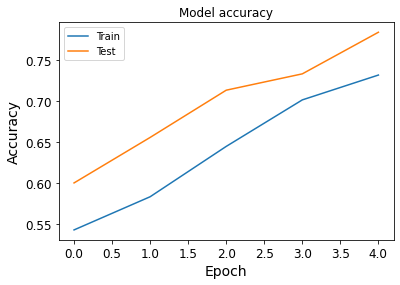

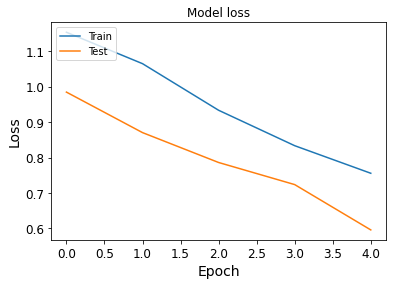

In [29]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

To my point above, the model accuracy for both the train and testing sets increased with the number of epochs. 

To evaluate a model, there are many methods are proposed to evaluate the model. I use Accuracy to evaluate the performance of my model.

In [30]:
# test_images,test_labels = get_images('../input/seg_test/seg_test/')
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)
model.evaluate(test_Images,test_Labels, verbose=1)

94/94 [==============================] - 92s 976ms/step - loss: 0.5992 - accuracy: 0.7907


[0.599215030670166, 0.7906666398048401]

We are returned a model accuracy of approximately 80% on the test set

In [68]:
#model.predict_classes This tensorflow attribute has been depracated

The get_image() function does not work here because the seg_pred directory is not split into folders of the photo types. The directory is filled with images of numeric labels. 

A different get_images() function had to be created for the prediction images because these images are not in a directory with the proper labels. Thus, we need to read the images from the one directory they exist in.

In [35]:
def get_pred_images(directory):
    Images = []
    #Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    #label = 0
    path = os.path.join(directory)
    for image in os.listdir(directory): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(os.path.join(path, image))#Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            image = np.array(image)
            image = image / 255
            Images.append(image)
            #Labels.append(label)
    
    return shuffle(Images, random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

this took approximately 23 seconds to run

For some reason, pred_images.shape will return an error. pred_images_2 was created as an np.array even though I defined the images to be arrays in the function.


In [69]:
pred_images = get_pred_images('C:/Users/Daniel/Downloads/Intel_images/seg_pred/')
pred_images_2 = np.array(pred_images)
print(pred_images_2.shape)

(7301, 150, 150, 3)


Following image shows the predicted class label on top of the image and probabilities below of the image.

C:\Users\Daniel\anaconda3\envs\sfds\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
C:\Users\Daniel\AppData\Local\Temp/ipykernel_10864/2706133583.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


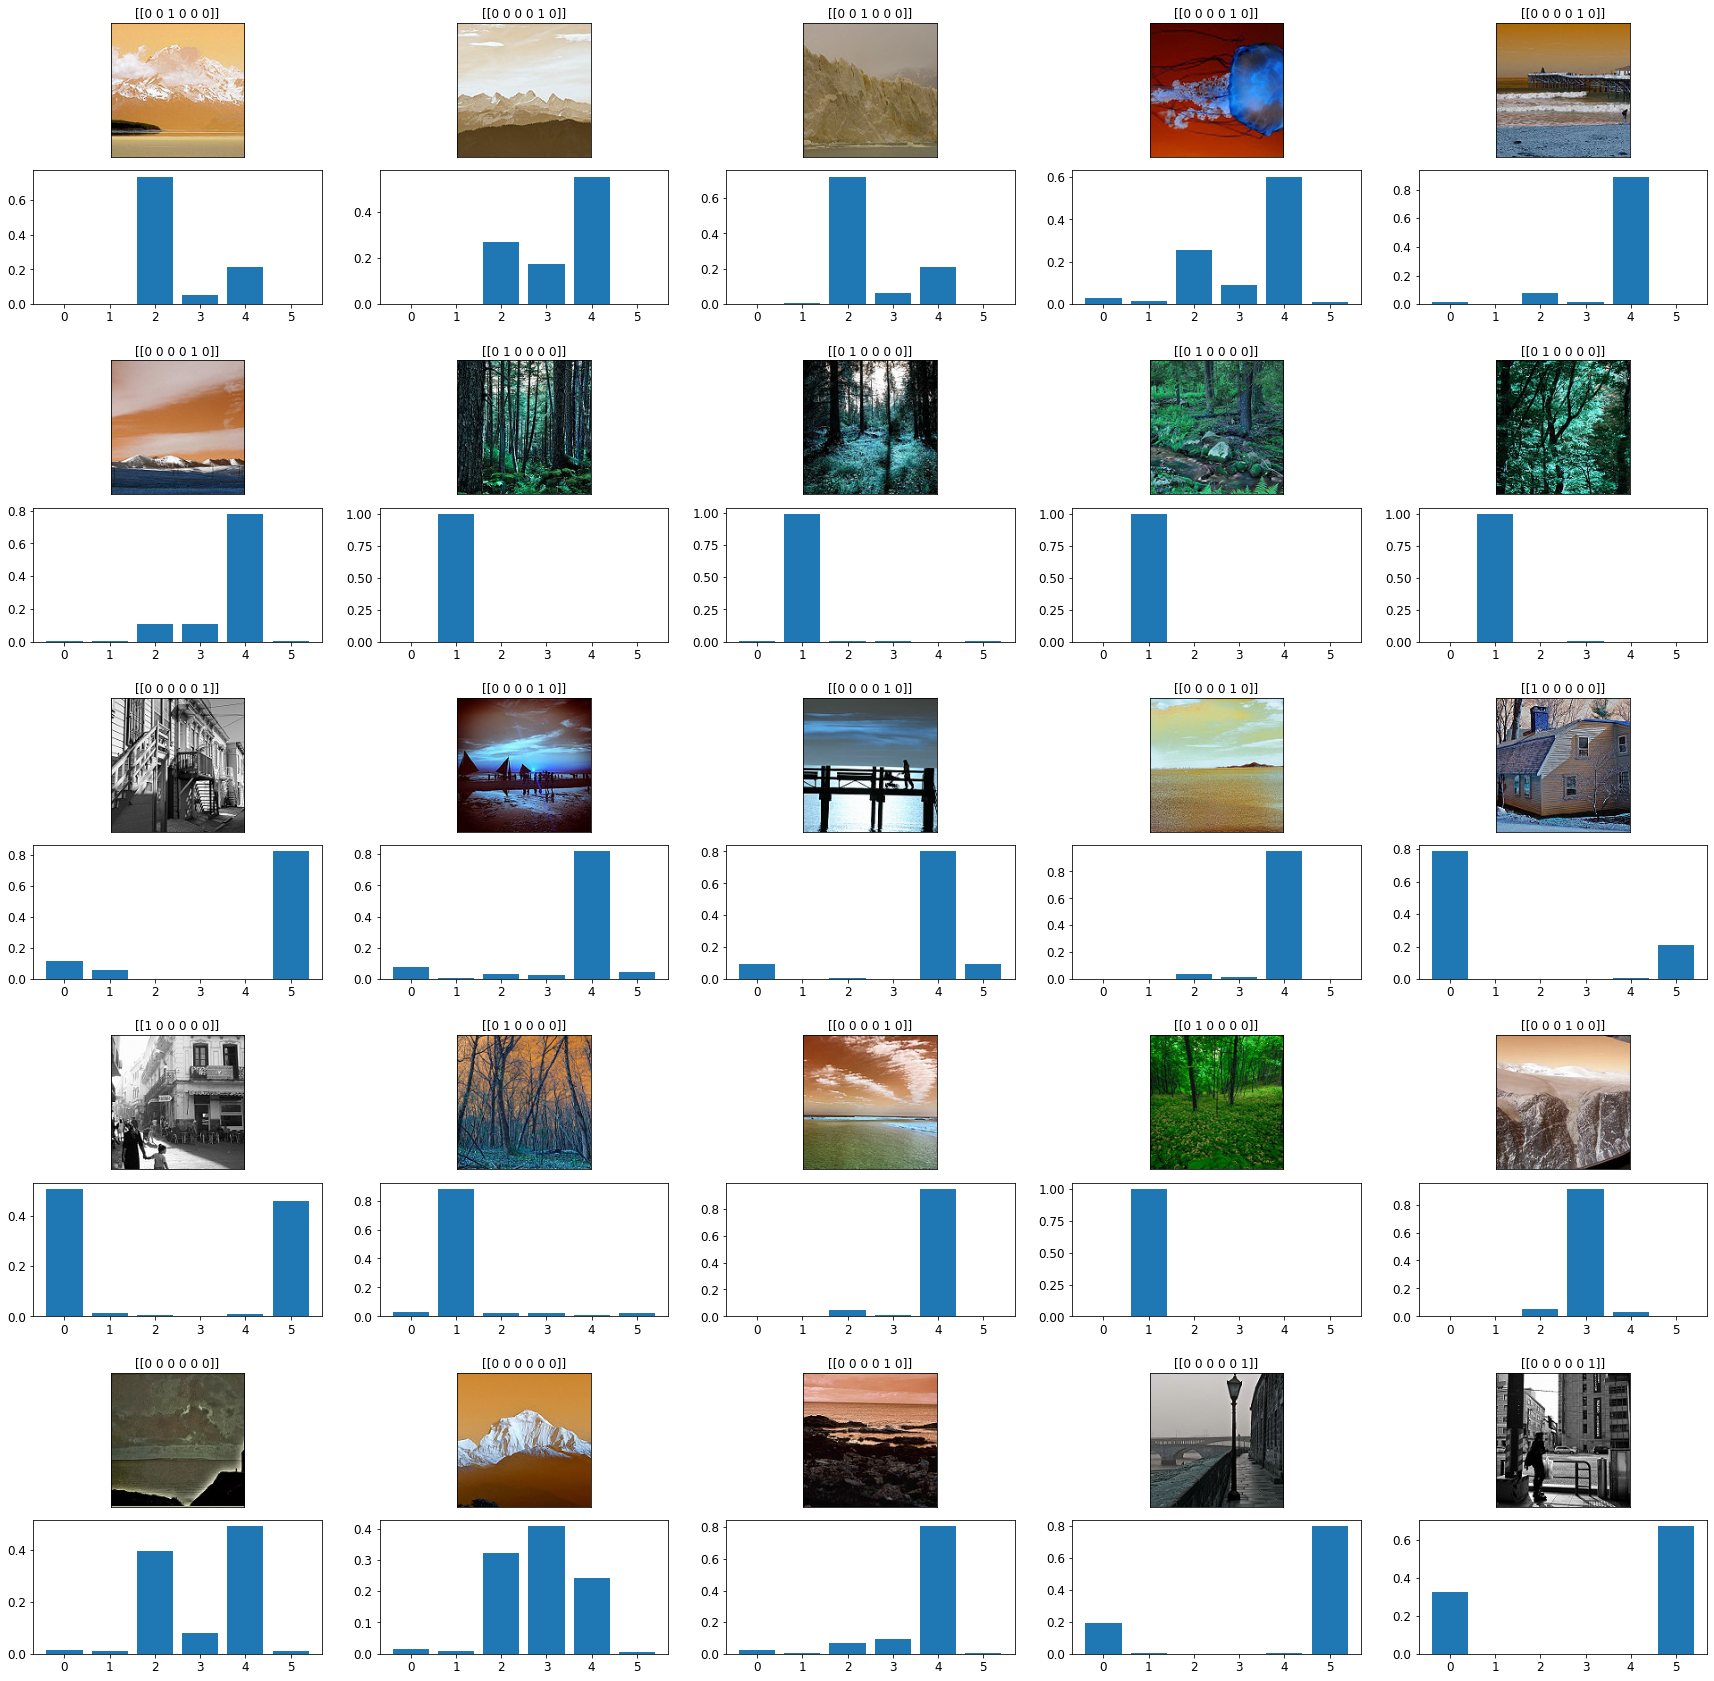

In [66]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images_2))
    pred_image = np.array([pred_images_2[rnd_number]])
    # pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    #pred_class = get_classlabel(np.argmax(model.predict(pred_image), axis = -1))
    pred_class = model.predict(pred_image)
    pred_class = np.round(pred_class).astype(int)
    #pred_class = get_classlabel(pred_class) 
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

Class labels : 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street

I was not able to display the labels of each image because "get_classlabel" returns an "unhashable type: 'numpy.ndarray'" error. 

## Code not used or not compatible with this assignment

In [71]:
# for layer in base_model.layers:
#     layer.trainable = False

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit(train_Images,
#                     steps_per_epoch=int(0.75 * train_dataset_size / batch_size),
#                     validation_data=valid_Images,
#                     validation_steps=int(0.15 * valid_dataset_size / batch_size),
#                     epochs=5).all()

In [72]:
# train_xint8 = tf.convert_to_tensor(train_Images, dtype=tf.int8)
# train_xfloat32 = tf.image.convert_image_dtype(train_xint8, dtype=tf.float32)
# print(train_xfloat32)

In [74]:
# for layer in base_model.layers:
#     layer.trainable = False

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit(train_xfloat32,
#                     steps_per_epoch=int(0.75 * train_dataset_size / batch_size),
#                     validation_data=valid_Images,
#                     validation_steps=int(0.15 * valid_dataset_size / batch_size),
#                     epochs=5).all()